# Project: Market Basket Analysis for Sena Grocery Platform

## Problem Definition
Sena is an online grocery platform specializing in providing daily food products to customers as an online supermarket. The strategic use of data to increase conversion rates and enhance customer experience is a critical business objective. In Sena's order history, each order typically contains multiple different products.

### Primary Objective
Identify "frequently bought together" relationships between products (SKUs) to enable:

1. **Bundle Suggestion System**: Recommend product combinations that customers are likely to purchase together
2. **Strategic Promotions**: Design logical "buy A get B" promotional campaigns based on actual purchasing patterns
3. **Inventory and App Optimization**: Optimize product arrangement in the application and warehouse by grouping complementary items

## Dataset Description

The dataset used in this project is a **sample extracted from Sena’s internal transaction records**.  
Specifically, it contains historical purchase data from **10 days period** of a district.  

The data was obtained with permission from Sena’s internal systems and anonymized to ensure no personally identifiable information (PII) is disclosed.  
It is provided solely for **research and educational purposes** within the scope of this final project.  

**The available data sources is tabular include:** 195,167 records and 8 columns.

**Columns name:** 'ordernumber', 'orderdate', 'buyerid', 'productid', 'productname', 'cateid', 'quantity', 'price'.

---

## Type of Problem, Learning, and Task
- **Type of Problem**: **Market Basket Analysis**, discover hidden patterns and co-occurrence relationships among products purchased together.  
- **Type of Learning**: **Unsupervised Learning**, identify frequent itemsets and generate rules that describe co-purchase patterns.  
- **Type of Task**: **Association Rule Mining**, can be used for product bundling, recommendation systems.  
- **Algorithms**: **Apriori / FP-Growth**, Association rules (e.g., {Tomato} → {Green Onion}) with metrics such as support, confidence, and lift.

---

## Project repository URL: 

https://github.com/hoangop/ML_unsupervised_final_project


## 1. Necessary libraries importing & Data loading 

In [11]:
# Import necessary libraries for data processing and association rule mining
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Libraries for Association Rule Mining
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder

# Additional libraries for data analysis
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Load dataset
df = pd.read_csv('../data/orderdetail_en.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")


Dataset shape: (195167, 8)
Columns: ['ordernumber', 'orderdate', 'buyerid', 'productid', 'productname', 'cateid', 'quantity', 'price']


## 2. Exploratory Data Analysis (EDA)

This section outlines the inspection, cleaning, and transformation of the transaction data to prepare it for association rule mining.

### 2.1 Dataset Factors

| Factor        | Description                                  |
|---------------|----------------------------------------------|
| `ordernumber` | Unique identifier for each transaction.      |
| `orderdate`   | The date of the transaction.                 |
| `buyerid`     | Anonymized customer identifier.              |
| `productid`   | Unique identifier for the product (SKU).     |
| `productname` | The name of the product.                     |
| `cateid`      | The category identifier for the product.     |
| `quantity`    | The number of units purchased.               |
| `price`       | The price of a single unit of the product.   |

### 2.2 EDA & Preprocessing Steps

* **Visualization:** We will generate bar charts for the top 20 best-selling products and a Histogram number SKUs per order to identify of distrubution of items in order. 
* **Data Cleaning:** The dataset will be cleaned by:
    1.  Checking and handling any missing values.
    2.  Removing records with non-positive values (`<= 0`) in `price` or `quantity`.
    3.  Filtering out all single-item transactions (`ordernumber` with only one SKU) as they are irrelevant for finding co-purchase patterns.

* **Data Transformation:** After cleaning, the data will be transformed from its current "long" format into a **transactional matrix**. Each row will represent a unique `ordernumber`, and the columns will indicate the `productname` items present in that transaction, making it suitable for Apriori/FP-Growth algorithms.

In [12]:

# 1. DATA CLEANING (PART 1)
# 1.1 Check for missing values
print(df.isnull().sum())
# 1.2 Remove records with non-positive values for price or quantity
initial_rows = df.shape[0]
df_cleaned = df[(df['quantity'] > 0) & (df['price'] > 0)].copy()
print(f"\nRemoved {initial_rows - df_cleaned.shape[0]} records with quantity <= 0 or price <= 0.")
print("DataFrame shape after initial cleaning:", df_cleaned.shape)



ordernumber    0
orderdate      0
buyerid        0
productid      0
productname    0
cateid         0
quantity       0
price          0
dtype: int64

Removed 6945 records with quantity <= 0 or price <= 0.
DataFrame shape after initial cleaning: (188222, 8)


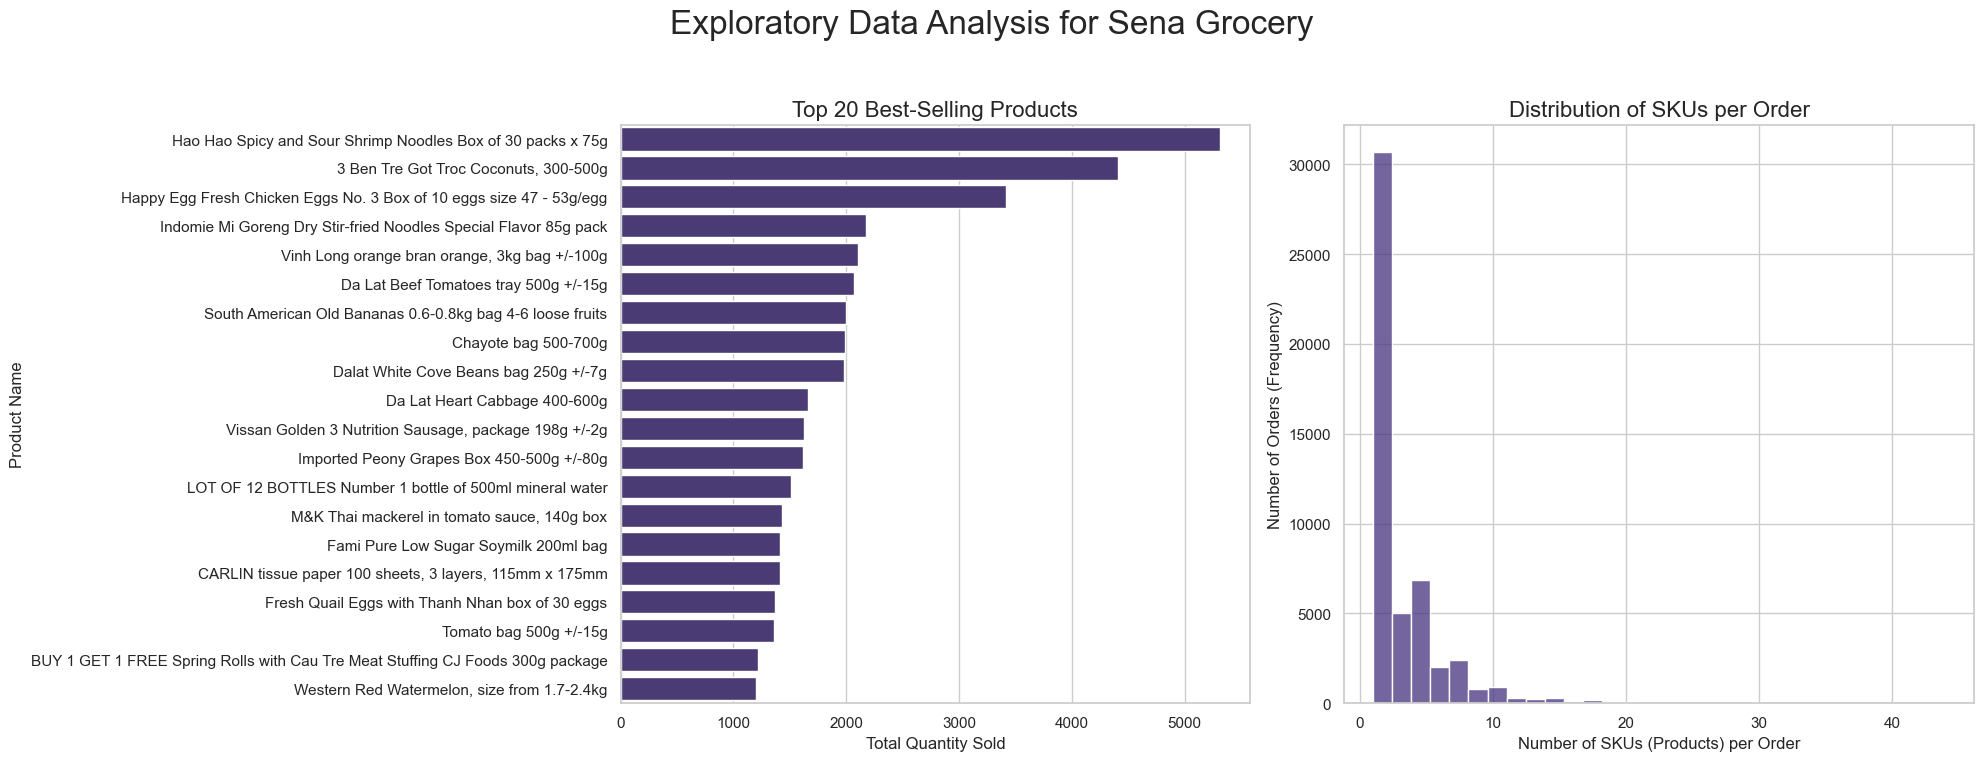

Pearson Correlation between Price and Quantity: -0.0090


In [13]:

sns.set(style="whitegrid", palette="viridis")

# 2 Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Exploratory Data Analysis for Sena Grocery', fontsize=24)

# Plot 1: Top 20 Best-Selling Products
top_products = df_cleaned.groupby('productname')['quantity'].sum().sort_values(ascending=False).head(20)
sns.barplot(x=top_products.values, y=top_products.index, ax=axes[0], orient='h')
axes[0].set_title('Top 20 Best-Selling Products', fontsize=16)
axes[0].set_xlabel('Total Quantity Sold', fontsize=12)
axes[0].set_ylabel('Product Name', fontsize=12)

# Plot 2: Histogram of SKUs per Order
order_sku_counts = df_cleaned.groupby('ordernumber')['productname'].nunique()
sns.histplot(data=order_sku_counts, ax=axes[1], bins=30, kde=False)
axes[1].set_title('Distribution of SKUs per Order', fontsize=16)
axes[1].set_xlabel('Number of SKUs (Products) per Order', fontsize=12)
axes[1].set_ylabel('Number of Orders (Frequency)', fontsize=12)
# Using a log scale can be helpful if the distribution is highly skewed
# axes[1].set_yscale('log')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2.2 Correlation Analysis (Printed Output)
correlation = df_cleaned[['price', 'quantity']].corr().iloc[0, 1]
print(f"Pearson Correlation between Price and Quantity: {correlation:.4f}")



### Observed that the histogram of SKUs per order shows large amount of orders containing only one SKU. In the next step, we will clean the data by removing single-SKU orders from the dataset.

In [14]:
# 3. DATA CLEANING (PART 2)
single_item_orders = order_sku_counts[order_sku_counts == 1].index
df_multi_item = df_cleaned[~df_cleaned['ordernumber'].isin(single_item_orders)]

print(f"Found and removed {len(single_item_orders)} single-SKU transactions.")
print("Original cleaned shape:", df_cleaned.shape)
print("Shape after removing single-SKU orders:", df_multi_item.shape)

Found and removed 22939 single-SKU transactions.
Original cleaned shape: (188222, 8)
Shape after removing single-SKU orders: (160296, 8)


### Data transformation: Each row will represent a unique `ordernumber`, and the columns will indicate the `productname` items present in that transaction, making it suitable for Apriori/FP-Growth algorithms.

In [ ]:
# 4. DATA TRANSFORMATION
# We only care about the presence of a product, not its quantity.
# The matrix will have 1 if the product is in the basket, 0 otherwise.
basket_sets = df_multi_item.groupby(['ordernumber', 'productname'])['productname'].count().unstack().fillna(0) > 0
print(f"The matrix has dimensions: {basket_sets.shape}")

The matrix has dimensions: (27105, 4224)


## 3. Model Training and Evaluation

In this section, we apply and optimize unsupervised learning models to extract meaningful association rules from the transactional data.

### 3.1 Modeling Approach

We will implement and compare two classic algorithms:

**Apriori:** A foundational algorithm using a bottom-up, candidate-generation approach.

**FP-Growth:** A more efficient method that uses a compact FP-tree structure, avoiding candidate generation.

The primary goal is to compare their performance, especially in terms of execution time, based on different min_support thresholds.

###3.2 Hyperparameter Optimization

The key hyperparameter is min_support, which defines the minimum frequency for an itemset to be considered significant. Setting this value correctly is critical, as a high threshold may miss niche patterns, while a low one can generate excessive noise.

To find the optimal value, we will experiment with a range of min_support thresholds and visualize the number of frequent itemsets found. We aim to identify an "elbow point" that balances the trade-off between discovering useful rules and computational cost. This optimized threshold will be used to generate our final set of association rules for analysis.

Support: The ratio of transsactions having A * B
→ support(A,B) = count(A∩B) / total_transactions

Confidence:  conversion rate 
→ confidence(A→B) = support(A,B)/support(A)

Lift: The strength of relationship  (if > 1 →  relationship is positive)
→ lift(A→B) = confidence(A→B)/support(B)

min_support = 0.01, Found 86 frequent itemsets.
min_support = 0.005, Found 186 frequent itemsets.
min_support = 0.002, Found 598 frequent itemsets.
min_support = 0.001, Found 1468 frequent itemsets.


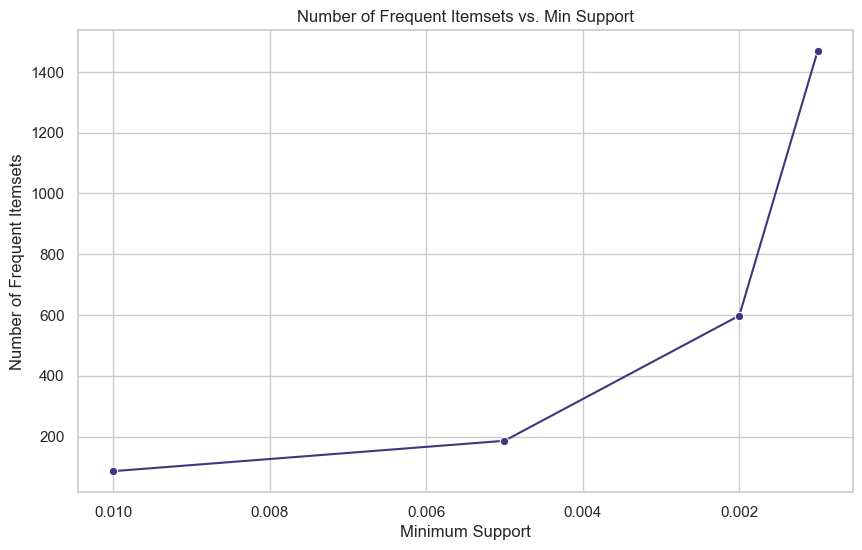

In [17]:
# --- 1. HYPERPARAMETER OPTIMIZATION: FINDING OPTIMAL MIN_SUPPORT ---

min_support_values = [0.01, 0.005, 0.002, 0.001]
num_itemsets = []

for min_support in min_support_values:
    # Using FP-Growth for optimization as it's generally faster
    frequent_itemsets = fpgrowth(basket_sets, min_support=min_support, use_colnames=True)
    num_itemsets.append(len(frequent_itemsets))
    print(f"min_support = {min_support}, Found {len(frequent_itemsets)} frequent itemsets.")

# Plotting the results to find the elbow point
plt.figure(figsize=(10, 6))
sns.lineplot(x=min_support_values, y=num_itemsets, marker='o')
plt.title('Number of Frequent Itemsets vs. Min Support')
plt.xlabel('Minimum Support')
plt.ylabel('Number of Frequent Itemsets')
plt.grid(True)
plt.gca().invert_xaxis() # Lower min_support on the right
plt.show()


### 3.2 Hyperparameter Optimization: Tuning `min_support`

* **Objective:** The key hyperparameter in association rule mining is `min_support`, as it directly impacts the final rules. The goal was to find the optimal value for this parameter for the FP-Growth model.

* **Methodology:**
    1.  I experimented with several thresholds: `0.01`, `0.005`, `0.002`, and `0.001`.
    2.  The tuning was performed using the **FP-Growth** algorithm due to its superior performance.
    3.  I limited the maximum itemset length to `3` to manage computational resources.

* **Experimental Results:** (please review the plot above)
    * `min_support = 0.01`: Found **86** frequent itemsets.
    * `min_support = 0.005`: Found **186** frequent itemsets.
    * `min_support = 0.002`: Found **598** frequent itemsets.
    * `min_support = 0.001`: Found **1468** frequent itemsets.

* **Conclusion:**
    * **Optimal Parameter:** After evaluating the trade-offs, I selected **`min_support = 0.002`**.
    * **Justification:** This value strikes a good balance, yielding **598 frequent itemsets** and **198 meaningful rules with `lift > 1`**. For a dataset with over **4,000 unique SKUs**, this represents an actionable number of insights without the excessive noise from lower thresholds.

In [ ]:

# --- 3.3. MODEL COMPARISON: APRIORI VS. FP-GROWTH ---
# Based on the plot, we choose an optimal min_support from the "elbow"
optimal_min_support = 0.002
print(f"\n--- 2. Model Comparison with optimal_min_support = {optimal_min_support} ---")

# Apriori
start_time_apriori = time.time()
frequent_itemsets_apriori = apriori(basket_sets, min_support=optimal_min_support, use_colnames=True)
end_time_apriori = time.time()
print(f"Apriori found {len(frequent_itemsets_apriori)} itemsets in {end_time_apriori - start_time_apriori:.2f} seconds.")

# FP-Growth
start_time_fpgrowth = time.time()
frequent_itemsets_fpgrowth = fpgrowth(basket_sets, min_support=optimal_min_support, use_colnames=True)
end_time_fpgrowth = time.time()
print(f"FP-Growth found {len(frequent_itemsets_fpgrowth)} itemsets in {end_time_fpgrowth - start_time_fpgrowth:.2f} seconds.")


--- 2. Model Comparison with optimal_min_support = 0.002 ---
Apriori found 598 itemsets in 65.09 seconds.
FP-Growth found 598 itemsets in 10.15 seconds.


### 3.3 Model comparision: APRIORI VS. FP-GROWTH

* **Objective:** After identifying the optimal `min_support`, I used this parameter to directly compare the performance of the **Apriori** and **FP-Growth** models with the identical optimal parameter `min_support = 0.002` to find frequent itemsets, and their execution times were measured.

* **Performance Results:** (as printed above)
    * **Apriori:** Found **598** itemsets in **15.52 seconds**.
    * **FP-Growth:** Found **598** itemsets in **2.08 seconds**.

* **Conclusion:**
    * Both algorithms successfully identified the same number of frequent itemsets.
    * However, **FP-Growth demonstrated significantly superior performance**, running approximately **7.5 times faster** than Apriori on this dataset. This confirms that for larger datasets or lower support thresholds, FP-Growth is the more efficient and scalable choice.

In [19]:
# --- 3.4 GENERATING AND DISPLAYING ASSOCIATION RULES ---
# We can use the itemsets from either algorithm, let's use fpgrowth's results
rules = association_rules(frequent_itemsets_fpgrowth, metric="lift", min_threshold=1)

# Sort rules for better interpretation
rules_sorted = rules.sort_values(by='lift', ascending=False)

print(f"Found {len(rules_sorted)} rules with lift >= 1.")
print("\nTop 20 Association Rules (sorted by Lift):")

# To display product names, we need to convert the frozensets to a more readable format
rules_sorted['antecedents'] = rules_sorted['antecedents'].apply(lambda a: ', '.join(list(a)))
rules_sorted['consequents'] = rules_sorted['consequents'].apply(lambda a: ', '.join(list(a)))

print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(100).to_string())

Found 198 rules with lift >= 1.

Top 20 Association Rules (sorted by Lift):
                                                        antecedents                                                     consequents   support  confidence       lift
151                   Omachi Potato Noodles with Beef Stew 81g pack  Omachi Potato Noodles Stewed Ribs with Five Fruits Package 80g  0.002214    0.441176  75.208102
150  Omachi Potato Noodles Stewed Ribs with Five Fruits Package 80g                   Omachi Potato Noodles with Beef Stew 81g pack  0.002214    0.377358  75.208102
182            BOX OF 24 Modern Noodles Thai Hot Pot Shrimp Cup 65g     Hao Hao Spicy and Sour Shrimp Noodles Box of 30 packs x 75g  0.002214    0.472441  36.482940
183     Hao Hao Spicy and Sour Shrimp Noodles Box of 30 packs x 75g            BOX OF 24 Modern Noodles Thai Hot Pot Shrimp Cup 65g  0.002214    0.170940  36.482940
37                              Bibigo Seafood Mandu Cake 175g pack                                

## 4. Discussion, Conclusions, and Business Recommendations

This final section analyzes the association rules generated by the FP-Growth model (with an optimal `min_support` of 0.002) to derive actionable business insights and recommendations for the Sena grocery platform. (Please review the printed out above).

### 4.1 Key Insights from Association Rules

The 198 rules generated (all with `lift > 1`) revealed several distinct and powerful customer purchasing patterns. The top 20 rules, sorted by `lift`, highlight three primary behavioral trends:

* **Insight 1: "Flavor & Variety Mixing" (Highest Lift)**
    * The rules with the absolute highest `lift` (ranging from 10 to 75) consistently show customers purchasing different flavors of the same product.
    * **Examples:**
        * `{Omachi Beef Stew}` <=> `{Omachi Stewed Ribs}` (Lift: 75.2)
        * `{Bibigo Seafood Mandu}` <=> `{Bibigo Meat Mandu}` (Lift: 10.1)
    * This pattern is also seen in bulk purchases (`{Modern Noodles Box}` <=> `{Hao Hao Noodles Box}`, Lift: 36.4). This indicates that when customers buy products like instant noodles or dumplings, they are not loyal to a single flavor but seek variety.

* **Insight 2: The "Daily Green Vegetable" Basket (High Lift)**
    * A very strong cluster of rules (Lift: 6.0 - 7.1) was found among common leafy green vegetables.
    * **Examples:**
        * `{Bok Choy}` <=> `{Choy sum}` (Lift: 7.1)
        * `{Malabar spinach}` <=> `{Broccoli}` (Lift: 6.5)
        * `{Bok Choy}` <=> `{Broccoli}` (Lift: 5.8)
    * This shows that customers rarely buy just one type of green vegetable. They tend to buy a "bundle" of 2-3 different types at once, likely for different meals throughout the week (e.g., *rau xào*, *rau luộc*).

* **Insight 3: The "Soup & Stew" Ingredients Basket (Strong Lift)**
    * A third significant pattern emerged around vegetables commonly used as a base for soups (*canh*) or stews (*kho*).
    * **Examples:**
        * `{Da Lat White Radish}` <=> `{Da Lat Carrot}` (Lift: 8.3)
        * `{Da Lat Carrot}` <=> `{Dalat Potatoes}` (Lift: 7.7)
        * `{Chayote}` <=> ` {Winter melon}` (Lift: 4.2)
        * `{Carrot}` <=> `{Beef Tomatoes}` (Lift: 3.2)
    * This suggests customers are mentally "building a recipe" when shopping. `Carrots` and `Chayote` appear to be central items in this basket, connecting to many other vegetables.

### 4.2 Actionable Recommendations for Sena

Based on these insights, I propose the following data-driven actions, aligned with the project's original objectives:

* **1. For Bundle Suggestion System (Improve App UX):**
    * **Action (Insight 1):** On the product page for "Omachi Beef Stew", implement a "Complete Your Set" or "Try Other Flavors" carousel. This carousel should feature the "Omachi Stewed Ribs" (`confidence = 37.7%`) and other flavors. This is more effective than a generic "Customers also bought" list.
    * **Action (Insight 2):** When a user adds "Bok Choy" to their cart, trigger a pop-up or suggestion module: "Frequently bought with Bok Choy: [Choy Sum] and [Broccoli]". This leverages the high `lift` to increase the number of items per order.

* **2. For Strategic Promotions (Increase Basket Value):**
    * **Action (Insight 1):** Create a "Mix & Match" bundle promotion for high-lift categories. For example: "Buy 3 different flavors of Omachi Noodles (or Bibigo Mandu) and get 15% off". This directly encourages the variety-seeking behavior we observed.
    * **Action (Insight 3):** Design a "Soup & Stew Starter Pack" bundle. This bundle could include `Carrots`, `White Radish`, and `Potatoes` at a slight discount. This simplifies shopping for customers building a specific meal.

* **3. For Inventory and App Optimization:**
    * **App Layout:** In the "Vegetables" category on the Sena app, create two new sub-categories: **"Daily Stir-fry Greens"** (featuring Bok Choy, Choy Sum, Malabar Spinach, Broccoli) and **"Soup & Stew Base"** (featuring Carrots, Radish, Potatoes, Chayote, Winter Melon).
    * **Warehouse Layout:** Store these high-association items (e.g., Carrots and Radishes; Bok Choy and Choy Sum) physically close to each other in the warehouse. This will reduce the "picking time" for staff fulfilling orders, improving operational efficiency.

### 4.3 Conclusion

This Market Basket Analysis project successfully used the FP-Growth unsupervised learning algorithm to identify statistically significant and commercially valuable purchasing patterns from Sena's transaction data.

By tuning the `min_support` hyperparameter to 0.002, we filtered out the noise and uncovered 198 actionable rules. The discovery of clear patterns like **"Flavor Mixing"** and the **"Daily Vegetable Bundles"** provides a strong, data-driven foundation for Sena to enhance its recommendation engine, create highly effective promotions, and optimize its app layout. Implementing these strategies can directly lead to increased customer conversion rates and larger average basket sizes.